# Cross-entropy method on CartPole (PyTorch)

In this notebook a cross-entropy method is applied for CartPole environment from OpenAI gym, with PyTorch. Cross-entropy method is :
- policy-based method
- on-policy method

The code is  based on the book: Deep Reinforcement Learning Hands-On, 2nd edition, from Packt publishing, by Maxim Lapan. The original code is taken from the GitHub pages of the book, and perhaps modified in some places.

## 1. Import packages

In [17]:
from collections import namedtuple
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


## 2. Build the model

In [4]:
HIDDEN_SIZE = 128
BATCH_SIZE = 16
PERCENTILE = 70

In [5]:
class Net(nn.Module):
  def __init__(self, obs_size, hidden_size, n_actions):
    super(Net,self).__init__()
    self.net=nn.Sequential(
        nn.Linear(obs_size,hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size,n_actions)
    )
  def forward(self,x):
    return self.net(x)

## 3. Play the Cartpole and create batches with Episodes

In [6]:
Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])

In [14]:
def iterate_batches(env, net, batch_size):
    batch = []
    episode_reward = 0.0
    episode_steps = []
    obs = env.reset()
    sm = nn.Softmax(dim=1)
    while True:
        obs_v = torch.FloatTensor([obs])
        act_probs_v = sm(net(obs_v))
        act_probs = act_probs_v.data.numpy()[0]
        action = np.random.choice(len(act_probs), p=act_probs)
        next_obs, reward, is_done, _ = env.step(action)
        episode_reward += reward
        step = EpisodeStep(observation=obs, action=action)
        episode_steps.append(step)
        if is_done:
            e = Episode(reward=episode_reward, steps=episode_steps)
            batch.append(e)
            episode_reward = 0.0
            episode_steps = []
            next_obs = env.reset()
            if len(batch) == batch_size:
                yield batch
                batch = []
        obs = next_obs

## 4. Select only the episodes with best rewards for training

In [15]:
# Remove those episodes from the batch where reward is not within the best percentile
def filter_batch(batch, percentile):
    rewards = list(map(lambda s: s.reward, batch))
    reward_bound = np.percentile(rewards, percentile)
    reward_mean = float(np.mean(rewards))

    train_obs = []
    train_act = []
    for reward, steps in batch:
        if reward < reward_bound:
            continue
        train_obs.extend(map(lambda step: step.observation, steps))
        train_act.extend(map(lambda step: step.action, steps))

    train_obs_v = torch.FloatTensor(train_obs)
    train_act_v = torch.LongTensor(train_act)
    return train_obs_v, train_act_v, reward_bound, reward_mean


## 5. Play the game to create batch of transitions and train the network with the best episodes

In [16]:
env = gym.make("CartPole-v0")
# env = gym.wrappers.Monitor(env, directory="mon", force=True)
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

net = Net(obs_size, HIDDEN_SIZE, n_actions)
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.01)

losses=[]
reward_means=[]
rw_boundaries=[]

for iter_no, batch in enumerate(iterate_batches(
        env, net, BATCH_SIZE)):
    obs_v, acts_v, reward_b, reward_m = \
        filter_batch(batch, PERCENTILE)
    optimizer.zero_grad()
    action_scores_v = net(obs_v)
    loss_v = objective(action_scores_v, acts_v)
    loss_v.backward()
    optimizer.step()
    losses.append(loss_v.item())
    reward_means.append(reward_m)
    rw_boundaries.append(reward_b)
    print(f"{iter_no}: loss={loss_v.item()}, reward_mean={reward_m}, rw_bound={reward_b}")
    if reward_m > 199:
        print("Solved!")
        break


0: loss=0.6870428323745728, reward_mean=20.3125, rw_bound=19.5
1: loss=0.6767308712005615, reward_mean=19.5625, rw_bound=23.0
2: loss=0.6791678071022034, reward_mean=18.1875, rw_bound=19.5
3: loss=0.6694231033325195, reward_mean=20.25, rw_bound=17.5
4: loss=0.690920889377594, reward_mean=23.375, rw_bound=25.0
5: loss=0.6825956106185913, reward_mean=25.1875, rw_bound=25.0
6: loss=0.6862876415252686, reward_mean=32.4375, rw_bound=39.5
7: loss=0.6651785969734192, reward_mean=30.6875, rw_bound=33.5
8: loss=0.6628185510635376, reward_mean=36.5625, rw_bound=44.0
9: loss=0.6706629991531372, reward_mean=31.75, rw_bound=40.0
10: loss=0.6510463356971741, reward_mean=38.375, rw_bound=45.0
11: loss=0.6446564793586731, reward_mean=42.625, rw_bound=55.5
12: loss=0.6283707022666931, reward_mean=31.5, rw_bound=37.0
13: loss=0.6391638517379761, reward_mean=43.25, rw_bound=50.0
14: loss=0.6336162686347961, reward_mean=48.3125, rw_bound=55.0
15: loss=0.6162010431289673, reward_mean=69.3125, rw_bound=76.0

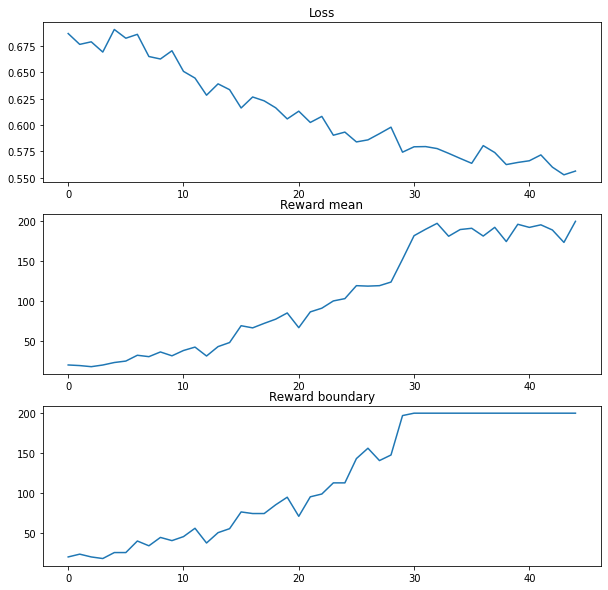

In [24]:
plt.figure(figsize=(10, 10))
charts=[losses,reward_means,rw_boundaries]
titles=['Loss','Reward mean','Reward boundary']
for i, (chart, title) in enumerate(zip(charts,titles)):
  ax=plt.subplot(3,1,i+1)
  plt.plot(chart)
  plt.title(title)